# Fusion 모델 학습 (수정 버전 v2)
### Audio Scaler 사용 + 텍스트 피처 실제 사용

**수정사항:**
- ⭐ Audio Scaler 사용 (03_train_audio와 동일하게!)
- ⭐ AUDIO_EMPHASIS_CLASSES = [1, 2, 3] (클래스 1도 강조!)
- 텍스트 피처를 `tensor.pt` + `text.json`에서 실제로 로드
- 텍스트 강조점수(>=0.7)도 자동 라벨링에 반영

# config.py 안에 학습 파라미터 이거로 수정

In [10]:
# config.py에서 불러오는 코드는 주석 처리하거나 무시하고
# from config import FUSION_CONFIG 

# 그냥 노트북 셀에 직접 정의해서 덮어씌웁니다.
# ✅ 3클래스 + Transformer 최적화 파라미터
FUSION_CONFIG = {
    "weights": {'gesture': 0.4, 'audio': 0.35, 'text': 0.25},
    "threshold": 0.6,
    "min_duration": 0.3,
    "batch_size": 128,  # ✅ 180 → 128 (안정성)
    "num_epochs": 50,   # ✅ 100 → 50 (충분)
    "lr": 5e-5,         # ✅ 1e-4 → 5e-5 (더 안정적)
    "gesture_dim": 512,
    "audio_dim": 128,
    "text_dim": 1024,
    "hidden_dim": 256,
}

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import glob
import json
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import cv2
import librosa
from tqdm import tqdm
import warnings
import gc
import random

warnings.filterwarnings('ignore')

from config import (
    GESTURE_CONFIG, AUDIO_CONFIG, VIDEO_RAW_DIR,
    GESTURE_MODEL_PATH, AUDIO_MODEL_PATH, FUSION_MODEL_PATH, AUDIO_SCALER_PATH,
    MODEL_DIR, ensure_dirs, TEXT_TENSORS_PATH, TEXT_SCORES_PATH
) #FUSION_CONFIG -나중에 다시 넣기기
from utils import (
    load_gesture_model, load_audio_model, create_text_model,
    create_fusion_model
)

ensure_dirs()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla P40


## 1. Audio Feature Extractor (⭐ Scaler 사용!)

In [12]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
from config import AUDIO_CONFIG

class AudioFeatureExtractorInferenceStyle:
    """
    Inference 코드와 100% 동일한 로직을 적용한 클래스
    1. 전체 오디오 Waveform Normalize
    2. Mel-Spectrogram -> dB
    3. 전체 오디오에 대해 StandardScaler 적용 (Global Scaling)
    """
    def __init__(self, config=None):
        if config is None:
            config = AUDIO_CONFIG
        
        self.sr = config.get('sample_rate', 16000)
        self.n_mels = config.get('n_mels', 80)
        self.n_fft = config.get('n_fft', 1024)
        self.hop_length = config.get('hop_length', 512)
        self.window_size = config.get('window_size', 50)
        
        print("✅ Audio Extractor 초기화 (Inference와 동일한 Global Scaling 모드)")
    
    def process_full_audio(self, y_audio):
        """전체 오디오를 한 번에 처리하여 피처맵 생성"""
        # 1. Waveform Normalization (전체 정규화)
        y_audio = librosa.util.normalize(y_audio)
        
        # 2. Mel-Spectrogram 추출
        mel = librosa.feature.melspectrogram(
            y=y_audio, sr=self.sr,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )
        features = librosa.power_to_db(mel, ref=np.max).T 
        
        # 3. Global Scaling (파일 전체에 대해 fit_transform)
        # Inference 코드와 동일하게 전체 통계량으로 정규화합니다.
        scaler = StandardScaler()
        try:
            features_norm = scaler.fit_transform(features)
        except ValueError:
            # 오디오가 너무 짧거나 무음인 경우 0으로 채움
            return np.zeros((0, self.n_mels), dtype=np.float32)

        return features_norm.astype(np.float32)

# --- 초기화 실행 ---
try:
    audio_extractor = AudioFeatureExtractorInferenceStyle(config=AUDIO_CONFIG)
    print("✅ Audio Extractor 적용 완료")
except Exception as e:
    print(f"❌ 초기화 실패: {e}")

✅ Audio Extractor 초기화 (Inference와 동일한 Global Scaling 모드)
✅ Audio Extractor 적용 완료


## 2. 텍스트 데이터 로드 함수

In [13]:
def load_text_data(tensor_path, json_path):
    """
    04_make_text.ipynb에서 생성한 텍스트 데이터 로드
    """
    text_tensors = []
    text_info = []
    
    if os.path.exists(tensor_path):
        tensors = torch.load(tensor_path)
        text_tensors = [t.squeeze(0) if t.dim() > 1 else t for t in tensors]
        print(f"  ✅ 텍스트 텐서 로드: {len(text_tensors)}개")
    else:
        print(f"  ⚠️ 텍스트 텐서 없음: {tensor_path}")
    
    if os.path.exists(json_path):
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        text_info = data.get('analysis', [])
        print(f"  ✅ 텍스트 정보 로드: {len(text_info)}개 문장")
    else:
        print(f"  ⚠️ 텍스트 정보 없음: {json_path}")
    
    return text_tensors, text_info


def get_text_feature_for_segment(start_sec, end_sec, text_tensors, text_info, current_video_path):
    """
    주어진 시간 구간 + 해당 비디오 파일에 맞는 텍스트 피처 반환
    """
    if not text_tensors or not text_info:
        return torch.zeros(1024)
    
    matching_tensors = []
    
    for i, info in enumerate(text_info):
        # 1. [중요] 비디오 경로(또는 파일명)가 일치하지 않으면 건너뜀!
        # info에 'video_path' 키가 있다고 가정 (데이터 생성 코드에서 추가함)
        # 경로가 완전히 같거나, 파일명이 포함되어 있으면 통과
        if 'video_path' in info:
             # 저장된 경로와 현재 처리 중인 경로가 다르면 스킵
             # (혹시 경로 포맷이 다를 수 있으니 파일명으로 비교하는 것이 더 안전할 수 있음)
            if os.path.basename(info['video_path']) != os.path.basename(current_video_path):
                continue

        # 2. 시간 구간 확인 (기존 로직)
        sent_start = info.get('start_sec', 0)
        sent_end = info.get('end_sec', 0)
        
        if not (sent_end <= start_sec or sent_start >= end_sec):
            if i < len(text_tensors):
                matching_tensors.append(text_tensors[i])
    
    if matching_tensors:
        stacked = torch.stack(matching_tensors)
        return stacked.mean(dim=0)
    else:
        return torch.zeros(1024)

## 3. 설정 (⭐ AUDIO_EMPHASIS_CLASSES 수정!)

In [14]:
# ===== 설정 =====
VIDEO_RAW_DIR = "/home/stu/ai_project/영상raw" #나중에 주소 바꾸기
SEGMENT_DURATION = 1.0
OVERLAP = 0.5

# ⭐⭐⭐ 중요! Audio 클래스 정의 ⭐⭐⭐
# 03_train_audio.ipynb에서:
#   클래스 0: 비강조 (Normal)
#   클래스 1: 침묵+강조 (Pause_Talk) ← 이것도 강조!
#   클래스 2: 높낮이+강조 (High_Tone)
#   클래스 3: 크게+강조 (Loud)

GESTURE_EMPHASIS_CLASSES = [1]      # Gesture: 클래스 1이 강조
AUDIO_EMPHASIS_CLASSES = [1, 2, 3]  # ⭐ Audio: 클래스 1, 2, 3이 모두 강조!

batch_size = FUSION_CONFIG.get('batch_size', 32)
num_epochs = FUSION_CONFIG.get('num_epochs', 20)
lr = FUSION_CONFIG.get('lr', 1e-3)

GPU_BATCH_SIZE = 32

print(f"VIDEO_RAW_DIR: {VIDEO_RAW_DIR}")
print(f"세그먼트: {SEGMENT_DURATION}초, 겹침: {OVERLAP*100}%")
print(f"\n⭐ GESTURE_EMPHASIS_CLASSES: {GESTURE_EMPHASIS_CLASSES}")
print(f"⭐ AUDIO_EMPHASIS_CLASSES: {AUDIO_EMPHASIS_CLASSES}")

VIDEO_RAW_DIR: /home/stu/ai_project/영상raw
세그먼트: 1.0초, 겹침: 50.0%

⭐ GESTURE_EMPHASIS_CLASSES: [1]
⭐ AUDIO_EMPHASIS_CLASSES: [1, 2, 3]


## 4. 모델 로드

In [15]:
print("\n🔧 모델 로드...")

g_model = load_gesture_model(GESTURE_MODEL_PATH, device)
a_model = load_audio_model(AUDIO_MODEL_PATH, device)
t_model = create_text_model().to(device)

g_model.eval()
a_model.eval()
t_model.eval()

for m in [g_model, a_model, t_model]:
    for p in m.parameters():
        p.requires_grad = False

print("✅ 모델 로드 완료")


🔧 모델 로드...
  ✅ Gesture Model 로드 완료: /home/stu/ai_project/모델집합/gesture_model.pt
  ✅ Audio Model 로드 완료: /home/stu/ai_project/모델집합/best_bi_lstm.pth
  ℹ️ Text Model: klue/roberta-large (Dim: 1024)
✅ 모델 로드 완료


## 5. 텍스트 데이터 로드

In [16]:
print("\n📝 텍스트 데이터 로드...")
TEXT_TENSORS, TEXT_INFO = load_text_data(TEXT_TENSORS_PATH, TEXT_SCORES_PATH)

print(f"\n텍스트 텐서 개수: {len(TEXT_TENSORS)}")
print(f"텍스트 정보 개수: {len(TEXT_INFO)}")

if TEXT_INFO:
    print(f"\n첫 번째 문장 예시:")
    print(f"  - 시작: {TEXT_INFO[0].get('start_sec', 0):.2f}초")
    print(f"  - 끝: {TEXT_INFO[0].get('end_sec', 0):.2f}초")
    print(f"  - 강조점수: {TEXT_INFO[0].get('emphasis_score', 0):.2f}")


📝 텍스트 데이터 로드...
  ✅ 텍스트 텐서 로드: 3080개
  ✅ 텍스트 정보 로드: 3080개 문장

텍스트 텐서 개수: 3080
텍스트 정보 개수: 3080

첫 번째 문장 예시:
  - 시작: 0.00초
  - 끝: 3.34초
  - 강조점수: 0.55


## 6. 헬퍼 함수 정의

In [17]:
def get_text_emphasis_score(start_sec, end_sec, current_video_path):
    """
    해당 구간 + 해당 비디오의 텍스트 강조 점수 반환 (비디오 매칭 추가!)
    """
    if not TEXT_INFO:
        return 0.0
    
    # 현재 파일명 추출 (확장자 제외)
    current_file_id = os.path.splitext(os.path.basename(current_video_path))[0]
    
    scores = []
    for info in TEXT_INFO:
        # 1. ⭐ [핵심] 비디오 파일명이 일치하는지 확인
        # (info에 'video_filename' 키가 없으면 건너뜀)
        info_file_id = info.get('video_filename', '')
        if info_file_id != current_file_id:
            continue

        # 2. 시간 구간 확인 (기존 로직)
        sent_start = info.get('start_sec', 0)
        sent_end = info.get('end_sec', 0)
        
        if not (sent_end <= start_sec or sent_start >= end_sec):
            scores.append(info.get('emphasis_score', 0.0))
    
    return max(scores) if scores else 0.0

## 7. 비디오 처리 함수 (⭐ Scaler 적용!)

In [18]:
def process_video_fast(video_path, segment_duration=1.0, overlap=0.5, 
                       clip_len=16, resize_hw=(112, 112)):
    """
    비디오 처리 함수 (수정됨): 
    오디오를 전체 변환 후 슬라이싱하여 Inference 코드와 정합성 확보
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None, []
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps if fps > 0 else 0
    
    if duration < segment_duration:
        cap.release()
        return None, None, []
    
    # 세그먼트 계산
    step = segment_duration * (1 - overlap)
    segments = []
    current = 0
    while current + segment_duration <= duration:
        segments.append((current, current + segment_duration))
        current += step
    
    if len(segments) == 0:
        cap.release()
        return None, None, []
    
    # --- 비디오 프레임 읽기 (기존과 동일) ---
    all_needed_frames = set()
    segment_frame_indices = []
    
    for start_sec, end_sec in segments:
        start_frame = int(start_sec * fps)
        end_frame = int(end_sec * fps)
        start_frame = max(0, min(start_frame, total_frames - 1))
        end_frame = max(start_frame + 1, min(end_frame, total_frames - 1))
        
        seg_len = end_frame - start_frame + 1
        if seg_len >= clip_len:
            indices = np.linspace(start_frame, end_frame, num=clip_len, dtype=int).tolist()
        else:
            base = np.linspace(start_frame, end_frame, num=seg_len, dtype=int).tolist()
            indices = (base * (clip_len // len(base) + 1))[:clip_len]
        
        segment_frame_indices.append(indices)
        all_needed_frames.update(indices)
    
    all_needed_frames = sorted(all_needed_frames)
    frame_cache = {}
    current_frame = 0
    needed_idx = 0
    
    while needed_idx < len(all_needed_frames):
        target_frame = all_needed_frames[needed_idx]
        while current_frame < target_frame:
            cap.grab()
            current_frame += 1
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, resize_hw)
            frame_cache[target_frame] = frame
        current_frame += 1
        needed_idx += 1
    
    cap.release()
    
    video_clips = []
    dummy_frame = np.zeros((resize_hw[0], resize_hw[1], 3), dtype=np.uint8)
    
    for indices in segment_frame_indices:
        frames = [frame_cache.get(i, dummy_frame) for i in indices]
        frames = np.stack(frames, axis=0).astype(np.float32) / 255.0
        frames = np.transpose(frames, (3, 0, 1, 2))
        frames = (frames - 0.5) / 0.5
        video_clips.append(torch.from_numpy(frames))
    
    # --- ⭐ 오디오 처리 (수정됨: 전체 처리 후 슬라이싱) ---
    audio_features_list = []
    try:
        y_full, sr = librosa.load(video_path, sr=AUDIO_CONFIG['sample_rate'])
        
        # 1. 전체 오디오를 Inference 코드와 똑같이 변환 (Normalize -> Mel -> Log -> Global Scale)
        full_audio_features = audio_extractor.process_full_audio(y_full)
        
        # 초당 프레임 수 계산 (SR / Hop_Length)
        frames_per_sec = sr / AUDIO_CONFIG['hop_length']
        window_size = AUDIO_CONFIG['window_size'] # 50
        
        for start_sec, end_sec in segments:
            # 시작 프레임 계산
            start_frame_idx = int(start_sec * frames_per_sec)
            
            # 50 프레임(Window Size)만큼 잘라내기
            if start_frame_idx < len(full_audio_features):
                feat_seg = full_audio_features[start_frame_idx : start_frame_idx + window_size]
            else:
                feat_seg = np.zeros((0, AUDIO_CONFIG['n_mels']))
            
            # 길이가 부족하면 패딩 (뒤쪽을 0으로 채움)
            if feat_seg.shape[0] < window_size:
                pad_len = window_size - feat_seg.shape[0]
                feat_seg = np.pad(feat_seg, ((0, pad_len), (0, 0)), mode='constant')
            
            # 길이가 넘치면 자름 (혹시 모를 경우 대비)
            feat_seg = feat_seg[:window_size]
            
            audio_features_list.append(torch.from_numpy(feat_seg).float())
            
    except Exception as e:
        print(f"❌ Audio processing error: {e}")
        # 에러 발생 시 0으로 채움
        audio_features_list = [torch.zeros(AUDIO_CONFIG['window_size'], AUDIO_CONFIG['n_mels'])] * len(segments)
    
    return video_clips, audio_features_list, segments

print("✅ 비디오 처리 함수 재정의 완료 (Audio Global Scaling 적용)")

✅ 비디오 처리 함수 재정의 완료 (Audio Global Scaling 적용)


## 8. 데이터 생성 함수

In [ ]:
@torch.no_grad()
def generate_all_data(video_raw_dir):
    """
    모든 비디오 처리하여 학습 데이터 생성 (3-Class 라벨링 적용)
    """
    video_files = sorted(glob.glob(os.path.join(video_raw_dir, "*.mp4")))
    print(f"\n📹 비디오 수: {len(video_files)}개")
    
    all_data = []
    
    # 디버그용 카운터
    audio_class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    # GESTURE_EMPHASIS_CLASSES, AUDIO_EMPHASIS_CLASSES 등은 config에서 로드된다고 가정합니다.
    
    for vid_idx, video_path in enumerate(video_files):
        video_name = os.path.basename(video_path)
        
        video_clips, audio_features, segments = process_video_fast(
            video_path,
            segment_duration=SEGMENT_DURATION,
            overlap=OVERLAP,
            clip_len=GESTURE_CONFIG['clip_len'],
            resize_hw=GESTURE_CONFIG['resize_hw']
        )
        
        if video_clips is None or len(video_clips) == 0:
            print(f"  [{vid_idx+1}/{len(video_files)}] {video_name}: 스킵")
            continue
        
        n_segs = len(video_clips)
        print(f"  [{vid_idx+1}/{len(video_files)}] {video_name}: {n_segs} 세그먼트", end=" ")
        
        for batch_start in range(0, n_segs, GPU_BATCH_SIZE):
            batch_end = min(batch_start + GPU_BATCH_SIZE, n_segs)
            
            batch_video = torch.stack(video_clips[batch_start:batch_end]).to(device)
            batch_audio = torch.stack(audio_features[batch_start:batch_end]).to(device)
            
            # 텍스트 피처 로드 (기존 로직 유지)
            batch_text_list = []
            for j in range(batch_start, batch_end):
                start_sec, end_sec = segments[j]
                text_feat = get_text_feature_for_segment(
                    start_sec, end_sec, TEXT_TENSORS, TEXT_INFO, video_path
                )
                batch_text_list.append(text_feat)
            
            batch_text = torch.stack(batch_text_list).to(device)
            
            # GPU 추론 (피처 및 예측값 추출)
            g_logits, g_feats = g_model(batch_video, return_feature=True)
            a_logits, a_feats = a_model(batch_audio, return_feature=True)
            _, t_feats = t_model(batch_text, return_feature=True)
            
            g_preds = torch.argmax(g_logits, dim=1).cpu().numpy()
            a_preds = torch.argmax(a_logits, dim=1).cpu().numpy()
            
            for j in range(batch_end - batch_start):
                seg_idx = batch_start + j
                g_pred = int(g_preds[j])
                a_pred = int(a_preds[j])
                start_sec, end_sec = segments[seg_idx]
                
                # 디버그: Audio 클래스 카운트
                audio_class_counts[a_pred] = audio_class_counts.get(a_pred, 0) + 1
                
                # ⭐ [수정 1] 비디오 경로(video_path)를 함께 전달하여 해당 영상의 텍스트만 가져옴
                text_emphasis = get_text_emphasis_score(start_sec, end_sec, video_path)
                
                # ⭐ [수정 2] 2/3 Voting 라벨링 로직 적용
                vote_score = 0

                # 1. 제스처 체크
                if g_pred in GESTURE_EMPHASIS_CLASSES:
                    vote_score += 1

                # 2. 오디오 체크 (클래스 1, 2, 3 중 하나면 +1)
                if a_pred in AUDIO_EMPHASIS_CLASSES:
                    vote_score += 1

                # 3. 텍스트 체크 (0.85 이상이면 +1)
                if text_emphasis >= 0.8:
                    vote_score += 1

                # ⭐ [최종 결정] 3가지 중 2가지 이상이 '강조'라고 해야 1로 인정
                auto_label = 1 if vote_score >= 2 else 0
                
                # 데이터 저장
                all_data.append({
                    'gesture_feat': g_feats[j].cpu(),
                    'audio_feat': a_feats[j].cpu(),
                    'text_feat': t_feats[j].cpu(),
                    'gesture_pred': g_pred,
                    'audio_pred': a_pred,
                    'text_emphasis': text_emphasis,
                    'auto_label': auto_label,
                    'video_path': video_path,
                    'start_sec': start_sec,
                    'end_sec': end_sec,
                })
            
        print("✓")
        
        del video_clips, audio_features
        gc.collect()
        torch.cuda.empty_cache()
    
    # 디버그 출력
    print(f"\n📊 최종 라벨 분포: {audio_class_counts}")
    
    return all_data


print("✅ 데이터 생성 함수 정의 완료")

✅ 데이터 생성 함수 정의 완료


## 9. 데이터 생성 또는 로드

⚠️ **중요**: 이전에 생성한 `auto_labeled_data_with_text.pt`가 있으면 삭제하고 새로 생성해야 합니다!

In [20]:
# ⭐ 기존 캐시 파일 삭제 (새로 생성해야 함!)
# 경로가 맞는지 확인하세요.
SAVE_PATH = os.path.join(MODEL_DIR, "auto_labeled_data_트랜스찐찐찐.pt")

# 기존 파일이 있다면 삭제 (그래야 새로 만듭니다)
if os.path.exists(SAVE_PATH):
    print(f"🗑️ 기존 파일 삭제 중: {SAVE_PATH}")
    os.remove(SAVE_PATH)

print("\n🚀 데이터 생성 시작...")
# 방금 정의한 함수가 여기서 실행됩니다
all_data = generate_all_data(VIDEO_RAW_DIR)

print(f"\n💾 데이터 저장 중... ({SAVE_PATH})")
torch.save(all_data, SAVE_PATH)
print("✅ 저장 완료!")


🚀 데이터 생성 시작...

📹 비디오 수: 62개
  [1/62] 1.mp4: 686 세그먼트 ✓
  [2/62] 10.mp4: 556 세그먼트 

KeyboardInterrupt: 

In [19]:
# 통계 출력
print(f"\n{'='*50}")
print(f"📊 총 세그먼트: {len(all_data)}")

labels = [d['auto_label'] for d in all_data]
num_pos = sum(labels)
num_neg = len(labels) - num_pos
print(f"📊 강조(1): {num_pos}, 비강조(0): {num_neg}")

g_preds = [d['gesture_pred'] for d in all_data]
a_preds = [d['audio_pred'] for d in all_data]
print(f"📊 Gesture: {dict(zip(*np.unique(g_preds, return_counts=True)))}")
print(f"📊 Audio: {dict(zip(*np.unique(a_preds, return_counts=True)))}")

text_emph = [d.get('text_emphasis', 0) for d in all_data]
high_text = sum(1 for t in text_emph if t >= 0.8)
print(f"📊 Text (>=0.8): {high_text}개")

# ⭐ Audio 클래스별 상세 분포
print(f"\n📊 Audio 클래스별 분포:")
print(f"   - 클래스 0 (Normal/비강조): {a_preds.count(0)}개")
print(f"   - 클래스 1 (Pause_Talk/강조): {a_preds.count(1)}개")
print(f"   - 클래스 2 (High_Tone/강조): {a_preds.count(2)}개")
print(f"   - 클래스 3 (Loud/강조): {a_preds.count(3)}개")


📊 총 세그먼트: 31716
📊 강조(1): 4540, 비강조(0): 27176
📊 Gesture: {0: 25194, 1: 6522}
📊 Audio: {0: 24385, 1: 1860, 2: 2963, 3: 2508}
📊 Text (>=0.8): 13184개

📊 Audio 클래스별 분포:
   - 클래스 0 (Normal/비강조): 24385개
   - 클래스 1 (Pause_Talk/강조): 1860개
   - 클래스 2 (High_Tone/강조): 2963개
   - 클래스 3 (Loud/강조): 2508개


## 10. Dataset & DataLoader

In [21]:
class FusionDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        d = self.data[idx]
        return (
            d['gesture_feat'], 
            d['audio_feat'], 
            d['text_feat'], 
            torch.tensor(d['auto_label'], dtype=torch.long)  # ✅ 3클래스용 Long 타입!
        )


# Train/Val 분할
random.seed(42)

video_groups = {}
for item in all_data:
    vp = item['video_path']
    if vp not in video_groups:
        video_groups[vp] = []
    video_groups[vp].append(item)

videos = list(video_groups.keys())
random.shuffle(videos)
split_idx = int(len(videos) * 0.8)
train_videos = set(videos[:split_idx])

train_data = [item for v, items in video_groups.items() if v in train_videos for item in items]
val_data = [item for v, items in video_groups.items() if v not in train_videos for item in items]

print(f"📊 Train: {len(train_data)}, Val: {len(val_data)}")

train_labels = [d['auto_label'] for d in train_data]

# ✅ 3클래스 가중치 계산
class_counts = [train_labels.count(i) for i in range(3)]
total = sum(class_counts)
# 클래스별 가중치: 적은 클래스에 더 큰 가중치
class_weights = torch.tensor([total / (3 * c) if c > 0 else 1.0 for c in class_counts]).to(device)
print(f"📊 클래스별 개수: Class0={class_counts[0]}, Class1={class_counts[1]}, Class2={class_counts[2]}")
print(f"📊 클래스 가중치: {class_weights.cpu().numpy()}")

train_loader = DataLoader(FusionDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(FusionDataset(val_data), batch_size=batch_size, shuffle=False)
print(f"📊 Batches - Train: {len(train_loader)}, Val: {len(val_loader)}")

📊 Train: 24484, Val: 7232
📊 Pos weight: 6.13
📊 Batches - Train: 137, Val: 41


## 11. Fusion 모델 생성

In [ ]:
import torch
import torch.nn as nn

# =============================================================================
# Transformer 기반 Fusion 모델 정의
# =============================================================================
class TransformerFusion(nn.Module):
    def __init__(self, gesture_dim, audio_dim, text_dim, hidden_dim, num_classes, 
                 use_text=True, dropout=0.5, nhead=4, num_layers=2):
        super(TransformerFusion, self).__init__()
        self.use_text = use_text
        
        # 1. 각 모달리티를 같은 차원(hidden_dim)으로 투영 (Projection)
        self.g_proj = nn.Linear(gesture_dim, hidden_dim)
        self.a_proj = nn.Linear(audio_dim, hidden_dim)
        if use_text:
            self.t_proj = nn.Linear(text_dim, hidden_dim)
            self.num_tokens = 3  # Gesture, Audio, Text
        else:
            self.num_tokens = 2  # Gesture, Audio

        # 2. 모달리티 구분을 위한 임베딩 (Learnable Positional Embedding 역할)
        self.modality_embed = nn.Parameter(torch.randn(1, self.num_tokens, hidden_dim))

        # 3. Transformer Encoder
        # batch_first=True: (Batch, Seq, Dim) 형태 유지를 위해 필수
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, 
            nhead=nhead, 
            dim_feedforward=hidden_dim * 4, 
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4. 분류기 (Classifier Head)
        # 모든 토큰의 출력을 펼쳐서(Flatten) 분류
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * self.num_tokens, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, gesture, audio, text=None):
        # (Batch, Input_Dim) -> (Batch, 1, Hidden_Dim)
        g_emb = self.g_proj(gesture).unsqueeze(1)
        a_emb = self.a_proj(audio).unsqueeze(1)
        
        tokens = [g_emb, a_emb]
        
        if self.use_text and text is not None:
            t_emb = self.t_proj(text).unsqueeze(1)
            tokens.append(t_emb)
            
        # 시퀀스로 결합: (Batch, Num_Tokens, Hidden_Dim)
        x = torch.cat(tokens, dim=1)
        
        # 모달리티 임베딩 더하기
        x = x + self.modality_embed
        
        # Self-Attention 수행 (상호작용 학습)
        x = self.transformer(x)
        
        # Flatten: (Batch, Num_Tokens * Hidden_Dim)
        x = x.reshape(x.size(0), -1)
        
        # 최종 분류
        return self.classifier(x)

# 2. 생성 함수 재정의 (Transformer 버전)
def create_fusion_model(gesture_dim, audio_dim, text_dim, hidden_dim, num_classes, use_text=True, dropout=0.5):
    # nhead는 hidden_dim(256)의 약수여야 함 (여기선 4로 설정 -> 헤드당 64차원)
    return TransformerFusion(
        gesture_dim, audio_dim, text_dim, hidden_dim, num_classes, 
        use_text=use_text, dropout=dropout, nhead=4, num_layers=2
    )

print("✅ Transformer 기반 Fusion 모델 정의 완료")

# =============================================================================
# 모델 생성 및 설정 (기존 설정 그대로 사용)
# =============================================================================

# 1. 모델 생성
f_model = create_fusion_model(
    gesture_dim=FUSION_CONFIG['gesture_dim'],
    audio_dim=FUSION_CONFIG['audio_dim'],
    text_dim=FUSION_CONFIG['text_dim'],
    hidden_dim=256,
    num_classes=3,  # ✅ 3클래스!
    use_text=True,
    dropout=0.4     # ✅ 0.5 → 0.4 (3만개 데이터에 적합)
).to(device)

# 2. Loss 정의 (✅ 3클래스용 CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 3. 옵티마이저 정의 (기존 lr 사용)
optimizer = optim.Adam(f_model.parameters(), lr=FUSION_CONFIG['lr'], weight_decay=1e-3)

# 4. 스케줄러 (선택사항, 기존 유지)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# 확인
print(f"📊 파라미터 개수: {sum(p.numel() for p in f_model.parameters()):,}")
print(f_model)

✅ Transformer 기반 Fusion 모델 정의 완료
📊 파라미터 개수: 2,204,161
TransformerFusion(
  (g_proj): Linear(in_features=512, out_features=256, bias=True)
  (a_proj): Linear(in_features=128, out_features=256, bias=True)
  (t_proj): Linear(in_features=1024, out_features=256, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (classifier): Sequ

## 12. 학습

In [23]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ===== 1. 지표 계산 함수 정의 =====
def calculate_metrics(y_true, y_pred):
    """
    정답(y_true)과 예측(y_pred)을 받아 Acc, Precision, Recall, F1(Macro)을 반환
    """
    # CPU로 이동 및 리스트 변환 (sklearn 사용 위해)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    acc = accuracy_score(y_true, y_pred)
    
    # average='macro': 클래스 불균형을 고려하여 각 클래스(0, 1)의 지표를 단순 평균
    # average='binary': 1(Positive) 클래스에 대한 지표만 계산 (일반적)
    # 여기서는 요청하신 'macro'와 일반적인 'binary' 중 선택 가능하나, 불균형 고려시 'macro' 추천
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    
    return acc, precision, recall, f1

# ===== 2. 학습 루프 설정 =====
history = {
    'train_loss': [], 'val_loss': [], 
    'train_acc': [], 'val_acc': [],
    'val_f1': [], 'val_precision': [], 'val_recall': [] # 기록용 리스트 추가
}

best_val_f1 = 0.0  # F1 Score 기준으로 Best 모델 저장 (Acc보다 더 신뢰성 높음)
patience_counter = 0
patience = 10

print(f"\n🚀 학습 시작! (epochs={num_epochs})")
print("=" * 90) # 구분선 길게

for epoch in range(num_epochs):
    # --- [Training Phase] ---
    f_model.train()
    train_loss = 0
    train_preds = []
    train_targets = []
    
    for g_feat, a_feat, t_feat, labels in train_loader:
        g_feat = g_feat.to(device)
        a_feat = a_feat.to(device)
        t_feat = t_feat.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = f_model(g_feat, a_feat, t_feat)  # ✅ squeeze 제거 (3클래스)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # ✅ 3클래스용 예측값 저장 (argmax 사용)
        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
    
    train_loss /= len(train_loader)
    # 학습 지표 계산
    train_acc, train_prec, train_rec, train_f1 = calculate_metrics(train_targets, train_preds)
    
    # --- [Validation Phase] ---
    f_model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for g_feat, a_feat, t_feat, labels in val_loader:
            g_feat = g_feat.to(device)
            a_feat = a_feat.to(device)
            t_feat = t_feat.to(device)
            labels = labels.to(device)
            
            outputs = f_model(g_feat, a_feat, t_feat)  # ✅ squeeze 제거 (3클래스)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            # ✅ 3클래스용 예측값 저장 (argmax 사용)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    # 검증 지표 계산
    val_acc, val_prec, val_rec, val_f1 = calculate_metrics(val_targets, val_preds)
    
    # 기록 저장
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # --- [로그 출력 & 저장] ---
    print(f"Epoch [{epoch+1:03d}/{num_epochs}] "
          f"Loss: {train_loss:.4f}/{val_loss:.4f} | "
          f"Acc: {train_acc*100:.1f}%/{val_acc*100:.1f}% | "
          f"F1(Macro): {val_f1:.4f} | Pre: {val_prec:.4f} | Rec: {val_rec:.4f}", end="")
    
    # F1 Score 기준으로 Best 모델 저장 (불균형 데이터일 때 더 좋음)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(f_model.state_dict(), os.path.join(MODEL_DIR, 'fusion_model_transformer_3class.pt'))
        print(f" ✅ Best F1!")
    else:
        patience_counter += 1
        print()
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            break

print("=" * 90)
print(f"\n✅ 학습 완료! Best Val F1: {best_val_f1:.4f}")
print(f"모델 저장: {os.path.join(MODEL_DIR, 'fusion_model_transformer_3class.pt')}")


🚀 학습 시작! (epochs=100)
Epoch [001/100] Loss: 0.8899/0.6867 | Acc: 72.2%/78.3% | F1(Macro): 0.6989 | Pre: 0.6808 | Rec: 0.8031 ✅ Best F1!
Epoch [002/100] Loss: 0.6629/0.6184 | Acc: 77.2%/76.6% | F1(Macro): 0.6928 | Pre: 0.6823 | Rec: 0.8236
Epoch [003/100] Loss: 0.6133/0.5961 | Acc: 76.8%/72.4% | F1(Macro): 0.6634 | Pre: 0.6743 | Rec: 0.8284
Epoch [004/100] Loss: 0.5845/0.6226 | Acc: 77.6%/74.5% | F1(Macro): 0.6793 | Pre: 0.6796 | Rec: 0.8311
Epoch [005/100] Loss: 0.5715/0.5893 | Acc: 77.5%/74.1% | F1(Macro): 0.6774 | Pre: 0.6806 | Rec: 0.8357
Epoch [006/100] Loss: 0.5391/0.5981 | Acc: 78.6%/77.0% | F1(Macro): 0.6970 | Pre: 0.6856 | Rec: 0.8290
Epoch [007/100] Loss: 0.5383/0.5566 | Acc: 79.2%/76.5% | F1(Macro): 0.6959 | Pre: 0.6876 | Rec: 0.8377
Epoch [008/100] Loss: 0.5275/0.5854 | Acc: 79.6%/82.6% | F1(Macro): 0.7387 | Pre: 0.7106 | Rec: 0.8211 ✅ Best F1!
Epoch [009/100] Loss: 0.5143/0.5695 | Acc: 80.2%/78.4% | F1(Macro): 0.7082 | Pre: 0.6915 | Rec: 0.8309
Epoch [010/100] Loss: 0.4997

## 13. 학습 결과 시각화

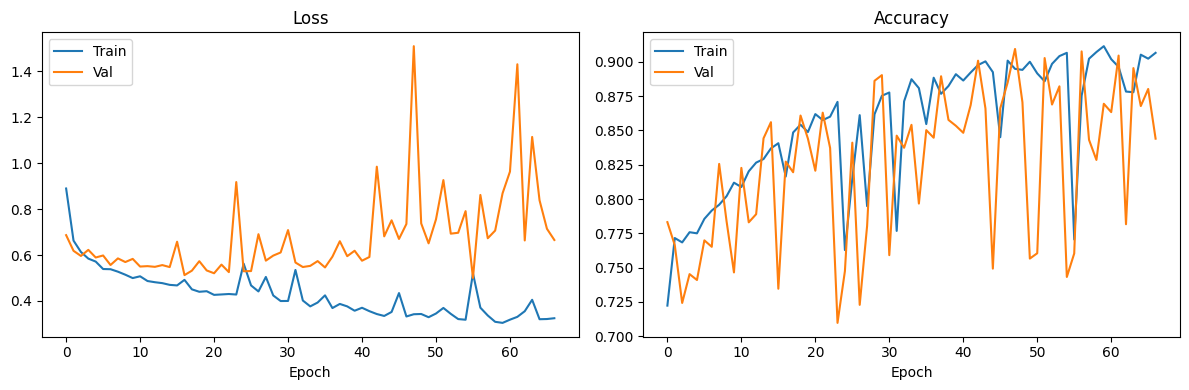


📊 그래프 저장: /home/stu/ai_project/모델집합/fusion_curves.png


In [24]:
with open(os.path.join(MODEL_DIR, "fusion_history.json"), 'w') as f:
    json.dump(history, f)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(history['train_loss'], label='Train')
ax[0].plot(history['val_loss'], label='Val')
ax[0].legend()
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')

ax[1].plot(history['train_acc'], label='Train')
ax[1].plot(history['val_acc'], label='Val')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'fusion_curves.png'))
plt.show()

print(f"\n📊 그래프 저장: {os.path.join(MODEL_DIR, 'fusion_curves.png')}")

## 완료!

### 수정사항 (v2):
1. ✅ **Audio Scaler 사용** - `audio_scaler.pkl` 로드해서 적용
2. ✅ **AUDIO_EMPHASIS_CLASSES = [1, 2, 3]** - 클래스 1도 강조로 인식
3. ✅ 텍스트 피처를 `tensor.pt`에서 실제로 로드
4. ✅ 텍스트 강조점수(>=0.7)도 자동 라벨링에 반영

### 생성된 파일:
- `모델집합/fusion_model.pt`
- `모델집합/auto_labeled_data_with_text_v2.pt` (새 버전)
- `모델집합/fusion_history.json`
- `모델집합/fusion_curves.png`

In [25]:
# 1. 라벨 재계산 로직
print("🔄 라벨링 기준 변경(2/3 Voting) 및 재계산 중...")
new_pos_count = 0
new_neg_count = 0

for item in all_data:
    g_pred = item['gesture_pred']
    a_pred = item['audio_pred']
    text_emphasis = item['text_emphasis']
    
    # [수정된 로직]
    vote_score = 0
    if g_pred in GESTURE_EMPHASIS_CLASSES: vote_score += 1
    if a_pred in AUDIO_EMPHASIS_CLASSES: vote_score += 1
    if text_emphasis >= 0.85: vote_score += 1
    
    new_label = 1 if vote_score >= 2 else 0
    
    # 데이터 업데이트
    item['auto_label'] = new_label
    
    # 카운팅
    if new_label == 1: new_pos_count += 1
    else: new_neg_count += 1

# 2. 결과 출력
print(f"\n✅ 재라벨링 완료!")
print(f"🔴 비강조(0): {new_neg_count}개")
print(f"🔵 강조(1): {new_pos_count}개")
ratio = new_pos_count / new_neg_count if new_neg_count > 0 else 0
print(f"비율: 1 대 {ratio:.2f}")

# (선택) 변경된 데이터를 저장해두고 싶다면
# torch.save(all_data, SAVE_PATH)

🔄 라벨링 기준 변경(2/3 Voting) 및 재계산 중...

✅ 재라벨링 완료!
🔴 비강조(0): 27176개
🔵 강조(1): 4540개
비율: 1 대 0.17


In [26]:
# 각 모델별 강조(1) 카운트 초기화
gesture_pos_count = 0
audio_pos_count = 0
text_pos_count = 0

print("📊 각 모델별 라벨링 현황 집계 중...")

for item in all_data:
    g_pred = item['gesture_pred']
    a_pred = item['audio_pred']
    text_emphasis = item.get('text_emphasis', 0.0) # 없으면 0.0 처리

    # 1. 제스처 모델이 강조로 본 경우
    if g_pred in GESTURE_EMPHASIS_CLASSES:
        gesture_pos_count += 1

    # 2. 오디오 모델이 강조로 본 경우
    if a_pred in AUDIO_EMPHASIS_CLASSES:
        audio_pos_count += 1

    # 3. 텍스트 점수가 기준 이상인 경우
    if text_emphasis >= 0.85:
        text_pos_count += 1

# 결과 출력
print(f"\n✅ 집계 완료 (총 세그먼트: {len(all_data)}개)")
print(f"✋ 제스처 강조(1): {gesture_pos_count}개 ({gesture_pos_count/len(all_data)*100:.1f}%)")
print(f"🎤 오디오 강조(1): {audio_pos_count}개 ({audio_pos_count/len(all_data)*100:.1f}%)")
print(f"📝 텍스트 강조(1): {text_pos_count}개 ({text_pos_count/len(all_data)*100:.1f}%)")

📊 각 모델별 라벨링 현황 집계 중...

✅ 집계 완료 (총 세그먼트: 31716개)
✋ 제스처 강조(1): 6522개 (20.6%)
🎤 오디오 강조(1): 7331개 (23.1%)
📝 텍스트 강조(1): 8858개 (27.9%)
